In [66]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [67]:
!pip install tensorflow keras numpy matplotlib pandas sklearn Bio torch 


In [68]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os

from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten, BatchNormalization
from keras.layers import Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator

In [69]:
print(os.listdir("/content/drive/My Drive/Colab_Notebooks/cat_dog/dataset/"))

['training_set', 'testing_set']


In [70]:
filenames = os.listdir("/content/drive/My Drive/Colab_Notebooks/cat_dog/dataset/training_set")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append('dog')
    else:
        categories.append('cat')

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [71]:
print(df.shape)
df.head()


(8010, 2)


,filename,category
0,dog.1176.jpg,dog
1,dog.1601.jpg,dog
2,dog.2281.jpg,dog
3,dog.1269.jpg,dog
4,dog.3227.jpg,dog


In [72]:
# Checking the distibution of categories.
df['category'].value_counts()

dog    4010
cat    4000
Name: category, dtype: int64

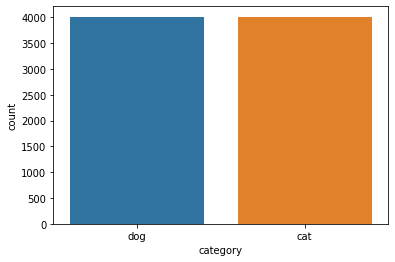

In [73]:
sns.countplot(x='category', data=df)

We can see that there are approximately same number of images of each category, only 10 images difference exist between dog and cat category.

We will now see a sample image from the 'train' set. Since each image has different dimension we will use a standard dimension of 128x128 which is a reduced version of the images' actual dimension.

In [74]:
filenames[0]

'dog.1176.jpg'

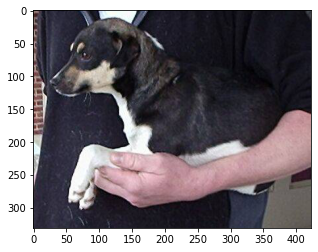

In [75]:
from tensorflow.keras.preprocessing import image
img = image.load_img("/content/drive/My Drive/Colab_Notebooks/cat_dog/dataset/training_set/"+filenames[0])
plt.imshow(img)

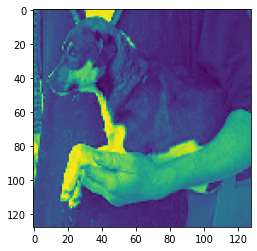

In [76]:
test_image = image.load_img("/content/drive/My Drive/Colab_Notebooks/cat_dog/dataset/training_set/"+filenames[0], 
                            target_size=(128, 128))
test_image = image.img_to_array(test_image)
plt.imshow(test_image[:, :, 2])

# **Prepare data**
Because we will use image genaretor with class_mode="categorical". We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification.

So we will convert 1 to dog and 0 to cat

In [77]:
# Create a validation set with 20% images from the 'train' set.
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(df, test_size=0.20, random_state=42)
train_data = train_data.reset_index(drop=True)
val_data   = val_data.reset_index(drop=True)

In [78]:
train_data.head()

,filename,category
0,dog.3513.jpg,dog
1,cat.3672.jpg,cat
2,cat.2131.jpg,cat
3,dog.1875(1).jpg,dog
4,dog.2073.jpg,dog


In [79]:
val_data.head()

,filename,category
0,dog.1399.jpg,dog
1,cat.2122.jpg,cat
2,dog.92.jpg,dog
3,cat.922.jpg,cat
4,dog.2337.jpg,dog


In [80]:
train_data['category'].value_counts()

cat    3214
dog    3194
Name: category, dtype: int64

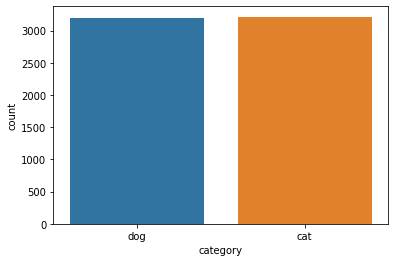

In [81]:
sns.countplot(x='category', data=train_data)

In [82]:
val_data['category'].value_counts()

dog    816
cat    786
Name: category, dtype: int64

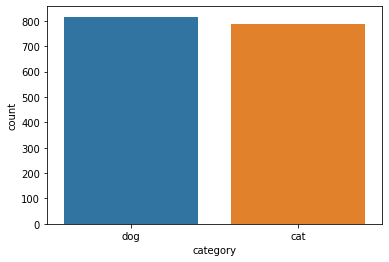

In [83]:
sns.countplot(x='category', data=val_data)

## **CNN Model**
A CNN will have multiple layers of Convolution layers and then it will be fed into a fully connected network.

In our case we will have 2 layers of Convolution Layers and each will have below features -

1.   Filters: The number of output filters in the convolution
2.   Kernel Size: The height and width of the convolution window

1.   Strides: The stride of the convolution
2.   Input Shape: The first Convolution layer will have input shape of 128x128x3 (128x128 is the image size and 3 specifies the channel as 'RGB')

Then we have Batch Normalization and Dropout as measure to prevent over-fitting and increase balance.

Max Pooling reduces the dimension of the cluster from one layer to the next by using the maximum value.

Flatten is used to change the dimension so that the output of Convolutional layer can be fed into a fully connected layer.

We are going to use ImageDataGenerator to preprocess the images.

In [84]:
#Build the CNN model
classifier = Sequential()

In [85]:
# add model layers
classifier.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), input_shape=(128,128,3),
                            padding='valid', activation='relu'))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(0.25))
classifier.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1),
                            padding='valid', activation='relu'))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(0.25))


classifier.add(Flatten())
classifier.add(Dense(512, activation='relu'))
classifier.add(BatchNormalization(),)
classifier.add(Dropout(0.5))
classifier.add(Dense(2, activation='softmax'))

In [86]:
#Compile the model
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [87]:
classifier.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_5 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
batch_normalization_6 (Batch (None, 61, 61, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 32)       

In [88]:
# Build the train_generator.
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

train_generator = train_datagen.flow_from_dataframe(
        train_data,
        "/content/drive/My Drive/Colab_Notebooks/cat_dog/dataset/training_set/",
        x_col='filename',
        y_col='category',
        target_size=(128, 128),
        batch_size=32,
        class_mode='categorical')

Found 6408 validated image filenames belonging to 2 classes.


In [89]:
# Build the validation_generator.
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_dataframe(
        val_data,
        "/content/drive/My Drive/Colab_Notebooks/cat_dog/dataset/training_set/",
        x_col='filename',
        y_col='category',
        target_size=(128, 128),
        batch_size=32,
        class_mode='categorical')

Found 1602 validated image filenames belonging to 2 classes.


## **See how our generator work**

In [90]:

example_df = train_data.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "/content/drive/My Drive/Colab_Notebooks/cat_dog/dataset/training_set/", 
    x_col='filename',
    y_col='category',
    target_size=(128, 128),
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


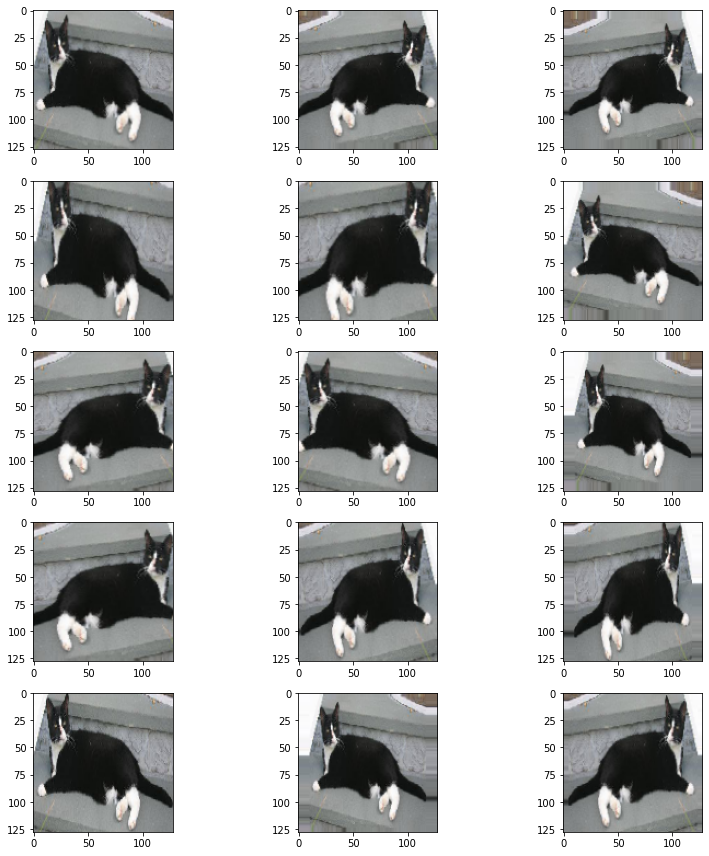

In [91]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## **Callbacks**

***Early Stop***

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [92]:
# Early Stop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)



In [ ]:
history=classifier.fit_generator(train_generator,
                                steps_per_epoch=625,
                                epochs=50,
                                validation_data=val_generator,
                                validation_steps=200,
                                callbacks=[es, mc])

Epoch 1/50
267/625 [===========>..................] - ETA: 1:59 - loss: 0.8997 - accuracy: 0.6026

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'], '')
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.title('Change of Accuracy over Epochs')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], '')
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.title('Change of Loss over Epochs')
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
train_generator.class_indices

In [ ]:
# Create a dataframe for the test data
test_filenames = os.listdir("/content/drive/My Drive/Colab_Notebooks/cat_dog/dataset/testing_set")
test_categories = []
test=[]
for filename in test_filenames:
    test_category = filename.split('.')[0]
    if test_category == 'dog':
        test_categories.append('dog')
        test.append(1)
    else:
        test_categories.append('cat')
        test.append(0)
print(test_categories[:5])
y_test=np.array(test)

test_data = pd.DataFrame({
    'test_filename': test_filenames,
    'test_category': test_categories
})

In [ ]:
# Load the best model.
from keras.models import load_model

saved_model = load_model('best_model.h5')

In [ ]:
# Use one sample image from test set and predict its class.
from tensorflow.keras.preprocessing import image
img = image.load_img("/content/drive/My Drive/Colab_Notebooks/cat_dog/dataset/testing_set/"+test_filenames[9])
                            
test_image = image.load_img("/content/drive/My Drive/Colab_Notebooks/cat_dog/dataset/testing_set/"+test_filenames[9], 
                            target_size=(128, 128))
test_image = image.img_to_array(test_image)
plt.imshow(img)
test_image = np.expand_dims(test_image, axis=0)
result = saved_model.predict(test_image)
print(np.argmax(result, axis=1))

In [ ]:
# Preprocess the images from test set.
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
        test_data,
        "/content/drive/My Drive/Colab_Notebooks/cat_dog/dataset/testing_set/",
        x_col='test_filename',
        y_col='test_category',
        target_size=(128, 128),
        batch_size=32,
        class_mode='categorical')


In [ ]:
#  Predict the classes of all the images from test set.
predict = saved_model.predict_generator(test_generator)
y_pred = np.argmax(predict, axis=1)

In [ ]:
print(y_pred[:20])

In [ ]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
results = confusion_matrix(y_test,y_pred) 
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(y_test,y_pred))
print ('Report : ')
print (classification_report(y_test,y_pred))

In [ ]:

from matplotlib import pyplot
from sklearn.metrics import roc_curve,auc
# calculate roc curves
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr,tpr)

# plot the roc curve for the model
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.plot(fpr,tpr,label="AUC= %0.2f" % roc_auc)
# show the legend
pyplot.plot([0, 1], [0, 1],'r--')
pyplot.xlim([0, 1])
pyplot.ylim([0, 1])
pyplot.title('Receiver operating Characteristics Curve (ROC)')
pyplot.legend(loc = "lower right")
# show the plot
pyplot.show()